In [71]:
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
import math

from scripts.plot import *
from scripts.baseline_prob_label_spreading import *
from scripts.probabilistic_label_spreading import prob_label_spreading
import time

from scipy.stats import entropy

from sklearn.model_selection import KFold, cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import silhouette_score, silhouette_samples
from scipy.stats import mode

plot_params = set_plot_layout(path_to_latex = '/home/jklees/texlive/bin/x86_64-linux') # set plot layout (optional)C

In [72]:
save_plots = True #  also leads to overwrite

In [73]:
# read CLIP zero shot results for comparison
clip_results = pd.read_csv("results/clip_zero_shot_results.csv")
clip_results.head()

,Unnamed: 0,dataset,zero_shot_accuracy,RMSE,MAE,KL,TV
0,0,CIFAR10,0.890360,0.127033,0.042580,0.382775,0.210397
1,1,CIFAR10-H,0.892400,0.110490,0.037451,0.303867,0.181454
2,2,ANIMALS10,0.977845,0.066169,0.012461,inf,0.061041
3,3,EMNIST,0.431675,0.288607,0.171834,2.042350,0.858368
4,4,TinyImageNet,0.571290,0.043686,0.005067,inf,0.433338


# 1 Performance comparison with baselines

## 1.1. For different hyperparameters on Cifar10-H

In [74]:
experiment = "vary_hyperparameters_on_CIFAR10-H" # name of the experiment that generated the results


metric = "RMSE" # metric to be analyzed

# Choose the dataspace for which the results are analyzed
dataset = "CIFAR10-H"
dim_reduction_technique = "CLIP+UMAP"
dim = 20

# get corresponding clip zero shot performance
clip_acc = clip_results.query(f"dataset == '{dataset}'")["zero_shot_accuracy"].values[0]
clip_score = clip_results.query(f"dataset == '{dataset}'")[metric].values[0]
clip_label = "CLIP zero shot" # "CLIP zero shot"

### 1.1.1 Gaussian process baseline results

In [75]:
gaussian_baseline_results = pd.read_csv(f"results/gaussian_baseline_{experiment}.csv")
filtered_results_gaussian = gaussian_baseline_results.query(f"dataset == '{dataset}' and dim_reduction_technique == '{dim_reduction_technique}' and dimension == {dim}")
# Group by hyperparameters and calculate mean and std for Accuracy and RMSE
filtered_results_gaussian = filtered_results_gaussian.groupby(
    ["gamma", "n_samples"], as_index=False
).agg(
    Accuracy=("Accuracy", "mean"),
    Accuracy_std=("Accuracy", "std"),
    RMSE=("RMSE", "mean"),
    RMSE_std=("RMSE", "std"),
    MAE=("MAE", "mean"),
    MAE_std=("MAE", "std"),
    KL=("KL", "mean"),
    KL_std=("KL", "std"),
    TV=("TV", "mean"),
    TV_std=("TV", "std")
)
filtered_results_gaussian.tail(2)

,gamma,n_samples,Accuracy,Accuracy_std,RMSE,RMSE_std,MAE,MAE_std,KL,KL_std,TV,TV_std
128,1000000.0,10000,0.64186,0.002203,0.184413,0.000626,0.072579,0.000483,1.663372,0.024467,0.358905,0.002449
129,1000000.0,100000,0.99126,0.000891,0.028831,0.000489,0.007808,0.000076,0.478601,0.002291,0.037397,0.000400


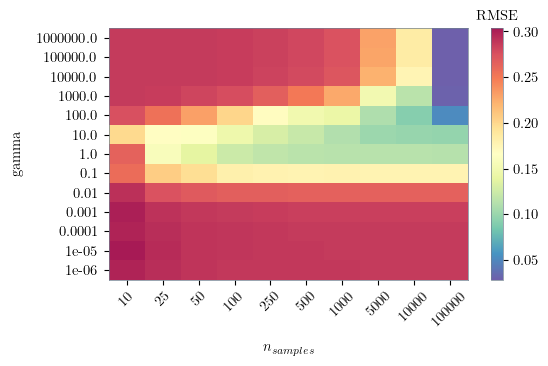

In [76]:
filename = f"RMSE_heatmap_gaussian_baseline_{dataset}_{dim_reduction_technique}_d={dim}.png" if save_plots else None

performance_heatmap(filtered_results_gaussian, ["n_samples", "gamma"], quantity= "RMSE", filename=filename)

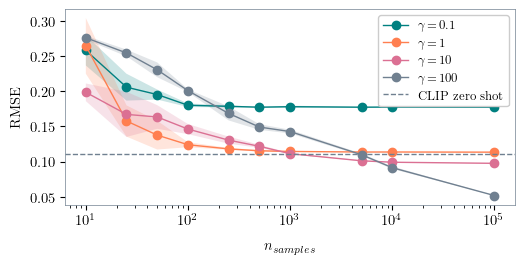

In [77]:
gammas = [0.1, 1, 10, 100]

filename = f"RMSE_trajectories_gaussian_baseline_{dataset}_{dim_reduction_technique}_d={dim}.png" if save_plots else None

if set(gammas).issubset(filtered_results_gaussian["gamma"]): #  if the specified values actually appear in the data
    fig, ax = performance_trajectories(filtered_results_gaussian, "gamma", gammas , quantity= "RMSE", display_std=True, filename=filename)
    ax.axhline(clip_score, ls = "dashed", color = "slategrey", label = clip_label)
    ax.legend()

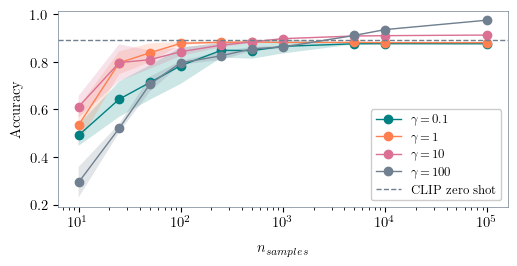

In [78]:
filename = f"accuracy_trajectories_gaussian_baseline_{dataset}_{dim_reduction_technique}_d={dim}.png" if save_plots else None

if set(gammas).issubset(filtered_results_gaussian["gamma"]): #  if the specified values actually appear in the data
    fig, ax = performance_trajectories(filtered_results_gaussian, "gamma", gammas , quantity= "Accuracy", display_std=True, filename=filename)
    ax.axhline(clip_acc, ls = "dashed", color = "slategrey", label = clip_label)
    ax.legend()

### 1.1.2 k nearest neighbors baseline results

In [79]:
knn_baseline_results = pd.read_csv(f"results/knn_baseline_{experiment}.csv")
filtered_results_knn = knn_baseline_results.query(f"dataset == '{dataset}' and dim_reduction_technique == '{dim_reduction_technique}' and dimension == {dim}")
# Group by hyperparameters and calculate mean and std for Accuracy and RMSE
filtered_results_knn = filtered_results_knn.groupby(
    ["k", "n_samples"], as_index=False
).agg(
    Accuracy=("Accuracy", "mean"),
    Accuracy_std=("Accuracy", "std"),
    RMSE=("RMSE", "mean"),
    RMSE_std=("RMSE", "std"),
    MAE=("MAE", "mean"),
    MAE_std=("MAE", "std"),
    KL=("KL", "mean"),
    KL_std=("KL", "std"),
    TV=("TV", "mean"),
    TV_std=("TV", "std")
)

filtered_results_knn.tail(2)

,k,n_samples,Accuracy,Accuracy_std,RMSE,RMSE_std,MAE,MAE_std,KL,KL_std,TV,TV_std
98,100,10000,0.89496,0.001623,0.108113,0.000148,0.031120,0.000111,NaN,NaN,0.149492,0.000578
99,100,100000,0.89774,0.000428,0.105700,0.000070,0.030237,0.000091,NaN,NaN,0.145245,0.000370


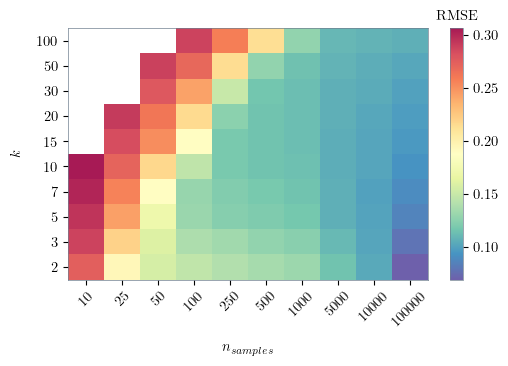

In [80]:
filename = f"RMSE_heatmap_knn_baseline_{dataset}_{dim_reduction_technique}_d={dim}.png" if save_plots else None

performance_heatmap(filtered_results_knn, ["n_samples", "k"], quantity= "RMSE", filename=filename)

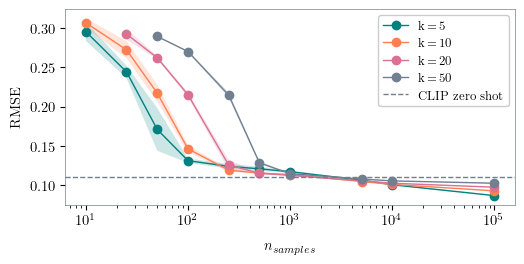

In [81]:
k_list = [5, 10, 20, 50]

filename = f"RMSE_trajectories_knn_baseline_{dataset}_{dim_reduction_technique}_d={dim}.png" if save_plots else None

if set(k_list).issubset(filtered_results_knn["k"]): #  if the specified values actually appear in the data
    fig, ax = performance_trajectories(filtered_results_knn, "k", k_list , quantity= "RMSE", display_std=True, filename=filename)
    ax.axhline(clip_score, ls = "dashed", color = "slategrey", label = clip_label)
    ax.legend()

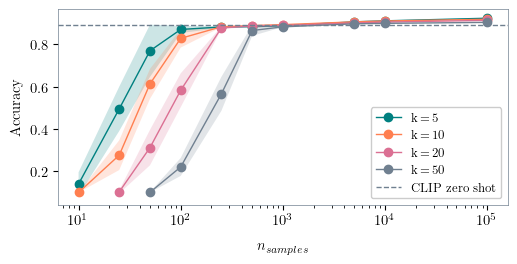

In [82]:
filename = f"accuracy_trajectories_knn_baseline_{dataset}_{dim_reduction_technique}_d={dim}.png" if save_plots else None
if set(k_list).issubset(filtered_results_knn["k"]): #  if the specified values actually appear in the data
    fig, ax= performance_trajectories(filtered_results_knn, "k", k_list , quantity= "Accuracy", display_std=True, filename=filename)
    ax.axhline(clip_acc, ls = "dashed", color = "slategrey", label = clip_label)
    ax.legend()

### 1.2.3 Probabilistic label spreading algorithm

In [83]:
prob_label_spreading_results = pd.read_csv(f"results/pls_{experiment}.csv")

In [84]:
# look at a fixed k

k = 20

filtered_results_pls = prob_label_spreading_results.query(f"k == {k} and dataset == '{dataset}' and dim_reduction_technique == '{dim_reduction_technique}' and dimension == {dim}")
# Group by hyperparameters and calculate mean and std for Accuracy and RMSE
filtered_results_pls = filtered_results_pls.groupby(
    ["k", "alpha", "n_samples"], as_index=False
).agg(
    Accuracy=("Accuracy", "mean"),
    Accuracy_std=("Accuracy", "std"),
    RMSE=("RMSE", "mean"),
    RMSE_std=("RMSE", "std"),
    MAE=("MAE", "mean"),
    MAE_std=("MAE", "std"),
    KL=("KL", "mean"),
    KL_std=("KL", "std"),
    TV=("TV", "mean"),
    TV_std=("TV", "std")
)
filtered_results_pls.tail(2)

,k,alpha,n_samples,Accuracy,Accuracy_std,RMSE,RMSE_std,MAE,MAE_std,KL,KL_std,TV,TV_std
98,20,0.999,10000,0.87712,0.001103,0.135558,0.000227,0.061393,0.000226,0.504957,0.001553,0.299350,0.001207
99,20,0.999,100000,0.87610,0.000406,0.135683,0.000063,0.061586,0.000118,0.500106,0.000448,0.300264,0.000582


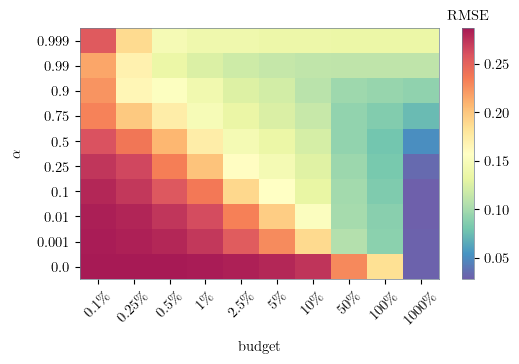

In [85]:
filename = f"RMSE_heatmap_PLS_{dataset}_{dim_reduction_technique}_d={dim}_k={k}.png" if save_plots else None
performance_heatmap(filtered_results_pls, ["n_samples", "alpha"], quantity= "RMSE", filename = filename, percentage=True, n_data = 10000)

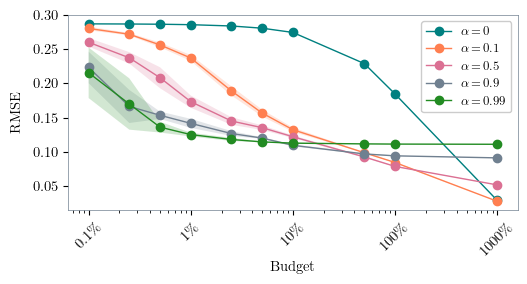

In [86]:
alphas = [0,0.1,0.5, 0.9, 0.99]

filename = f"plots/RMSE_trajectories_PLS_{dataset}_{dim_reduction_technique}_d={dim}_k={k}.png" if save_plots else None
if set(alphas).issubset(filtered_results_pls["alpha"]): #  if the specified values actuall appear in the data
    fig, ax = performance_trajectories(filtered_results_pls, "alpha", alphas , quantity= "RMSE", display_std=True, filename = None)
    #ax.axhline(clip_rmse, ls = "dashed", color = "slategrey", label = clip_label)
    ax.set_xlabel("Budget", labelpad = 2)
    ax.set_ylabel("RMSE", labelpad = 7)

    ax.set_xticks( np.array([10, 100, 1000, 10000, 100000]) )
    ax.set_xticklabels([f"{x / 100: .1f}\%" for x in [10]] + [f"{int(x / 100)}\%" for x in np.array([100, 1000, 10000, 100000])], rotation=45)
    ax.legend()
    if filename:
        fig.savefig(filename, bbox_inches='tight', dpi = 300)

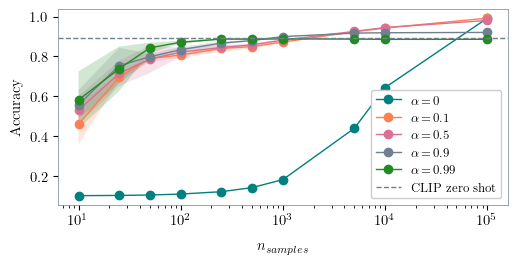

In [87]:
filename = f"accuracy_trajectories_PLS_{dataset}_{dim_reduction_technique}_d={dim}_k={k}.png" if save_plots else None
if set(alphas).issubset(filtered_results_pls["alpha"]): #  if the specified values actually appear in the data
    fig, ax = performance_trajectories(filtered_results_pls, "alpha", alphas , quantity= "Accuracy", display_std=True, filename = filename)
    ax.axhline(clip_acc, ls = "dashed", color = "slategrey", label = clip_label)
    ax.legend()

In [88]:
# consider the impact of k, fix alpha = 0.5, 0.9, 0.99

results_k = prob_label_spreading_results[prob_label_spreading_results["alpha"].isin([0.1, 0.5, 0.9, 0.99])].query(f"dataset == '{dataset}' and dim_reduction_technique == '{dim_reduction_technique}' and dimension == {dim}")
# Group by hyperparameters and calculate mean and std for Accuracy and RMSE
results_k = results_k.groupby(
    ["k", "alpha", "n_samples"], as_index=False
).agg(
    Accuracy=("Accuracy", "mean"),
    Accuracy_std=("Accuracy", "std"),
    RMSE=("RMSE", "mean"),
    RMSE_std=("RMSE", "std"),
    MAE=("MAE", "mean"),
    MAE_std=("MAE", "std"),
    KL=("KL", "mean"),
    KL_std=("KL", "std"),
    TV=("TV", "mean"),
    TV_std=("TV", "std")
)
results_k.tail(2)

,k,alpha,n_samples,Accuracy,Accuracy_std,RMSE,RMSE_std,MAE,MAE_std,KL,KL_std,TV,TV_std
398,100,0.99,10000,0.88096,0.001001,0.120991,0.000072,0.048304,0.000138,0.404133,0.001131,0.234060,0.000708
399,100,0.99,100000,0.88108,0.000390,0.120914,0.000028,0.048295,0.000076,0.394603,0.000427,0.234147,0.000388


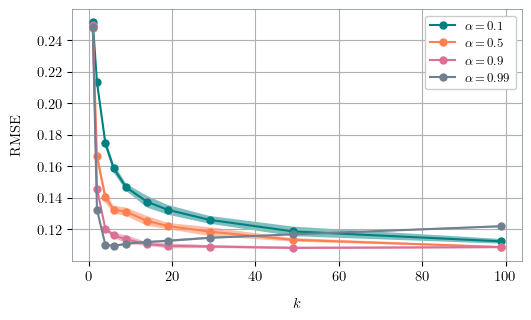

In [89]:
fig = plt.figure()
ax = plt.gca()
plt.grid()

for n_samples in [1000]: # 100, 1000
    for alpha in results_k["alpha"].unique():
        X = np.array(results_k.query(f"alpha == {alpha} and n_samples == {n_samples}")["k"].unique())
        Y = np.array([results_k.query(f"alpha == {alpha} and n_samples == {n_samples} and k == {x}")["RMSE"] for x in X]).flatten()
        Y_std = np.array([results_k.query(f"alpha == {alpha} and n_samples == {n_samples} and k == {x}")["RMSE_std"] for x in X]).flatten()

        label = r"$\alpha$" +  f"\,=\,{alpha:.3g}" # + r", $n_{samples}\,=\,$"+  f"{n_samples}"

        ax.plot(X-1,Y, lw = 1.5, marker = "o", ms = 5, label=label) # f"{label}\,=\,{alpha:.3g}"

        ax.fill_between(X-1, Y - Y_std, Y + Y_std, alpha = 0.5)

plt.legend()
plt.xlabel("$k$")
plt.ylabel("RMSE")

if save_plots:
    plt.savefig("plots/Performance of PLS on CIFAR10 depending on k.png")

plt.show()

In [90]:
# fix a number of samples and analyze the hyperparameters jointly

n_samples = 10000 # 100, 1000

filtered_results_pls_b = prob_label_spreading_results.query(f"n_samples == {n_samples} and dataset == '{dataset}' and dim_reduction_technique == '{dim_reduction_technique}' and dimension == {dim}")
# Group by hyperparameters and calculate mean and std for Accuracy and RMSE
filtered_results_pls_b = filtered_results_pls_b.groupby(
    ["n_samples", "k", "alpha"], as_index=False
).agg(
    Accuracy=("Accuracy", "mean"),
    Accuracy_std=("Accuracy", "std"),
    RMSE=("RMSE", "mean"),
    RMSE_std=("RMSE", "std"),
    MAE=("MAE", "mean"),
    MAE_std=("MAE", "std"),
    KL=("KL", "mean"),
    KL_std=("KL", "std"),
    TV=("TV", "mean"),
    TV_std=("TV", "std")
)
filtered_results_pls_b.tail(2)

,n_samples,k,alpha,Accuracy,Accuracy_std,RMSE,RMSE_std,MAE,MAE_std,KL,KL_std,TV,TV_std
98,10000,100,0.990,0.88096,0.001001,0.120991,0.000072,0.048304,0.000138,0.404133,0.001131,0.234060,0.000708
99,10000,100,0.999,0.87590,0.000886,0.161379,0.000346,0.080958,0.000149,0.682641,0.002220,0.396878,0.000856


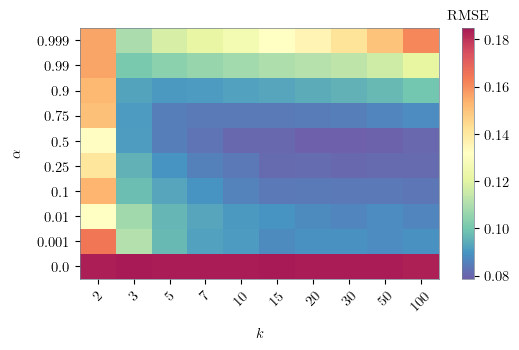

In [91]:
filename = f"RMSE_heatmap_PLS_alpha_and_k_{dataset}_{dim_reduction_technique}_d={dim}_n_samples={n_samples}.png" if save_plots else None
performance_heatmap(filtered_results_pls_b, ["k", "alpha"], quantity= "RMSE", filename = filename)


### 1.1.4 Comparison


Select the optimal parameter for each algorithm and compare the performance


In [92]:
filtered_results_knn.query("k == 20")

,k,n_samples,Accuracy,Accuracy_std,RMSE,RMSE_std,MAE,MAE_std,KL,KL_std,TV,TV_std
60,20,10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
61,20,25,0.10284,0.007294,0.292079,0.006986,0.169133,0.000727,NaN,NaN,0.831192,0.001944
62,20,50,0.31186,0.083672,0.261981,0.002127,0.145763,0.000905,NaN,NaN,0.718452,0.004274
63,20,100,0.58304,0.079801,0.214981,0.003036,0.105153,0.001556,NaN,NaN,0.515702,0.009077
64,20,250,0.87748,0.006279,0.125808,0.006744,0.044628,0.003852,NaN,NaN,0.215555,0.019209
65,20,500,0.88696,0.002425,0.115276,0.000369,0.035438,0.000937,NaN,NaN,0.170643,0.004536
66,20,1000,0.88910,0.001183,0.112592,0.000280,0.032652,0.000888,NaN,NaN,0.157320,0.004372
67,20,5000,0.90132,0.001847,0.105705,0.000408,0.030447,0.000320,NaN,NaN,0.146294,0.001548
68,20,10000,0.90528,0.000971,0.102624,0.000204,0.029162,0.000358,NaN,NaN,0.139964,0.001657
69,20,100000,0.91322,0.000396,0.097588,0.000149,0.027138,0.000112,NaN,NaN,0.130035,0.000525


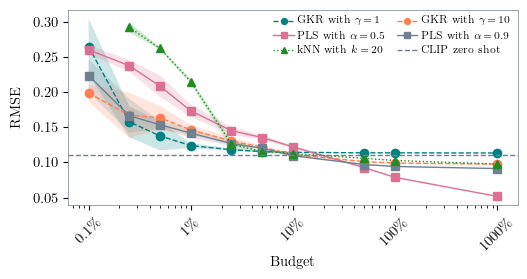

In [93]:
filename = f"{metric}_trajectory_comparison"

alphas = [0.5, 0.9] # 

gammas = [1, 10] #
k_list = [20] #

fig, ax = compare_performance_trajectories(filtered_results_gaussian, "gamma", gammas, 
                                            filtered_results_pls, "alpha", alphas, 
                                            filtered_results_knn, "k", k_list, 
                                            quantity = metric, display_std = True, filename = filename, linestyles=["dashed", "solid", "dotted"])
ax.axhline(clip_score, ls = "dashed", color = "slategrey", label = clip_label)

ax.set_xticks( np.array([10, 100, 1000, 10000, 100000]) )
ax.set_xticklabels([f"{x / 100: .1f}\%" for x in [10]] + [f"{int(x / 100)}\%" for x in np.array([100, 1000, 10000, 100000])], rotation=45)
ax.set_xlabel("Budget", labelpad = 2)

handles, labels = ax.get_legend_handles_labels()
order = [0, 2, 4, 1, 3, 5]  # column-wise for ncol=3

handles = [handles[i] for i in order]
labels  = [labels[i]  for i in order]
ax.legend(handles, labels, ncols = 2, loc="lower center", bbox_to_anchor=(0.72, 0.72), frameon=False,
            fontsize=10,
            prop={'size': 7.5},
            handlelength=2,
            handletextpad=0.3,
            markerscale=0.7,
            columnspacing=1.0
            )

if save_plots:
    fig.savefig("plots/" + filename.split(".")[0] , bbox_inches='tight', dpi=300)

plt.show()

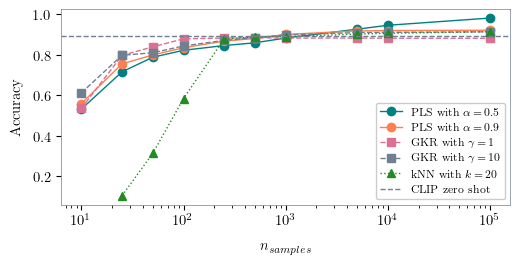

In [94]:
filename = f"comparison_of_accuracy_trajectories_{dataset}_{dim_reduction_technique}_d={dim}_k={k}.png" if save_plots else None

fig, ax = compare_performance_trajectories(filtered_results_pls, "alpha", alphas, filtered_results_gaussian, "gamma", gammas, 
                                 filtered_results_knn, "k", k_list, quantity = "Accuracy", filename = filename)
ax.axhline(clip_acc, ls = "dashed", color = "slategrey", label = clip_label)
ax.legend(prop = {"size": 8})   

plt.show()                 

## 1.2 performance on different datasets

In [95]:
experiment = "evaluate_all_datasets"
gaussian_baseline_results = pd.read_csv(f"results/gaussian_baseline_{experiment}.csv")
knn_baseline_results = pd.read_csv(f"results/knn_baseline_{experiment}.csv")
pls_results = pd.read_csv(f"results/pls_{experiment}.csv")

gaussian_baseline_results = gaussian_baseline_results.groupby(
    ["dataset", "gamma", "n_samples"], as_index=False
).agg(
    Accuracy=("Accuracy", "mean"),
    Accuracy_std=("Accuracy", "std"),
    RMSE=("RMSE", "mean"),
    RMSE_std=("RMSE", "std"),
)

knn_baseline_results = knn_baseline_results.groupby(
    ["dataset", "k", "n_samples"], as_index=False
).agg(
    Accuracy=("Accuracy", "mean"),
    Accuracy_std=("Accuracy", "std"),
    RMSE=("RMSE", "mean"),
    RMSE_std=("RMSE", "std"),
)

pls_results = pls_results.groupby(
    ["dataset", "k", "alpha", "n_samples"], as_index=False
).agg(
    Accuracy=("Accuracy", "mean"),
    Accuracy_std=("Accuracy", "std"),
    RMSE=("RMSE", "mean"),
    RMSE_std=("RMSE", "std"),
)

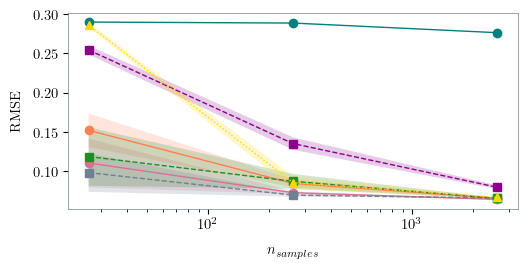

In [96]:
dataset_name = "ANIMALS10"
alphas = [0, 0.9, 0.99]
gammas = [1, 10, 100]
k_list = [20]

filename = f"comparison_of_RMSE_trajectories_on_{dataset_name}.png" if save_plots else None

fig, ax = compare_performance_trajectories(pls_results.query(f"dataset == '{dataset_name}'"), "alpha", alphas,
                                 gaussian_baseline_results.query(f"dataset == '{dataset_name}'"), "gamma", gammas, 
                                 knn_baseline_results.query(f"dataset == '{dataset_name}'"), "k", k_list, 
                                 quantity = "RMSE", display_std=True, filename = filename)

In [97]:
# build one large table here with all the results
import pandas as pd
from IPython.display import Markdown
experiment = "evaluate_all_datasets"
datasets = ["TwoMoons","ANIMALS10", "EMNIST", "CIFAR10", "CIFAR10-H" ,"TinyImageNet", "MTSD"]
#header = ["Algorithm"] + ["TwoMoons","Anim.10", "EMNIST-d.", "CIF.10", "CIF.10-H" ,"Tiny I.N.", "MTSD"]
header = ["Algorithm"] + [r"\rot{TwoMoons}",r"\rot{Anim.10}", r"\rot{EMNIST-d.}", r"\rot{CIF.10}", r"\rot{CIF.10-H}" ,r"\rot{Tiny I.N.}", r"\rot{MTSD}"]

na_placeholder = np.nan

values = {0: 0.001, 1: 0.01, 2: 0.1} # , 3: 1

v = 1

alphas = [0.5, 0.9, 0.99, 0.999]
gammas = [0.1, 1, 10]
k_list = [5, 20, 50]
results = pd.read_csv(f"results/pls_{experiment}.csv")
results = results.groupby(
    ["dataset", "n_data", "alpha", "n_samples"], as_index=False
).agg(
    Accuracy=("Accuracy", "mean"),
    Accuracy_std=("Accuracy", "std"),
    RMSE=("RMSE", "mean"),
    RMSE_std=("RMSE", "std"),
)


# add results of hyperparameter optimization

optimization_results = pd.read_pickle("results/optimization_results.pkl")


rows = []

for alpha in alphas:
    row = ["PLS, $\\alpha$ = " + str(alpha)]
    for dataset_name in datasets:
        n_data = results.query(f"dataset == '{dataset_name}'")["n_data"].values[0]
        n_samples = int(n_data * values[v])
        row.append(results.query(f"dataset == '{dataset_name}' and alpha == {alpha} and n_samples == {n_samples}")["RMSE"].values[0])
    rows.append(row)

algorithm = "PLS"
row = [algorithm + ", optimized"]
for dataset_name in datasets:
    try:
        row.append(optimization_results.query(f"algorithm == '{algorithm}' and dataset_name == '{dataset_name}' and proportion == {values[v]}")["rmse"].values[0])
    except:
        row.append(na_placeholder)
rows.append(row)

results = pd.read_csv(f"results/gaussian_baseline_{experiment}.csv")
results = results.groupby(
    ["dataset", "n_data", "gamma", "n_samples"], as_index=False
).agg(
    Accuracy=("Accuracy", "mean"),
    Accuracy_std=("Accuracy", "std"),
    RMSE=("RMSE", "mean"),
    RMSE_std=("RMSE", "std"),
)
for gamma in gammas:
    row = ["GM, $\\gamma$ = " + str(gamma)]
    for dataset_name in datasets:
        n_data = results.query(f"dataset == '{dataset_name}'")["n_data"].values[0]
        n_samples = int(n_data * values[v])
        row.append(results.query(f"dataset == '{dataset_name}' and gamma == {gamma} and n_samples == {n_samples}")["RMSE"].values[0])
    rows.append(row)

algorithm = "GM"
row = [algorithm + ", optimized"]
for dataset_name in datasets:
    try:
        row.append(optimization_results.query(f"algorithm == '{algorithm}' and dataset_name == '{dataset_name}' and proportion == {values[v]}")["rmse"].values[0])
    except:
        row.append(na_placeholder)
rows.append(row)


results = pd.read_csv(f"results/knn_baseline_{experiment}.csv")
results = results.groupby(
    ["dataset", "n_data", "k", "n_samples"], as_index=False
).agg(
    Accuracy=("Accuracy", "mean"),
    Accuracy_std=("Accuracy", "std"),
    RMSE=("RMSE", "mean"),
    RMSE_std=("RMSE", "std"),
)
for k in k_list:
    row = ["kNN, $k$ = " + str(k)]
    for dataset_name in datasets:
        n_data = results.query(f"dataset == '{dataset_name}'")["n_data"].values[0]
        n_samples = int(n_data * values[v])
        row.append(results.query(f"dataset == '{dataset_name}' and k == {k} and n_samples == {n_samples}")["RMSE"].values[0])
    rows.append(row)

algorithm = "kNN"
row = [algorithm + ", optimized"]
for dataset_name in datasets:
    try:
        row.append(optimization_results.query(f"algorithm == '{algorithm}' and dataset_name == '{dataset_name}' and proportion == {values[v]}")["rmse"].values[0])
    except:
        row.append(na_placeholder)
rows.append(row)


# add clip zero shot results
clip_results = pd.read_csv("results/clip_zero_shot_results.csv")
row = ["CLIP zero shot"]
for dataset_name in datasets:
    if dataset_name in clip_results["dataset"].values:
        row.append(clip_results.query(f"dataset == '{dataset_name}'")["RMSE"].values[0])
    else:
        row.append(na_placeholder)
rows.append(row)


# generate the table in latex format
table = pd.DataFrame(rows, columns = header)

# Find min values (excluding first column)
min_vals = table.iloc[:, 1:].min()

# Formatter function to format numbers and highlight the minimum
def format_value(x, col):
    if col == header[0]:  # First column, no formatting
        return str(x)
    return f"\\textbf{{{x:.3f}}}" if x == min_vals[col] else f"{x:.3f}"

# Apply formatting
table_formatted = table.apply(lambda col: col.apply(lambda x: format_value(x, col.name)))

# # Generate LaTeX code with tabularx
latex_code = table_formatted.to_latex(
    index=False, escape=False
).replace(
    "\\begin{tabular}", f"\\begin{{tabularx}}{{\\linewidth}}"
).replace(
    "\\end{tabular}", f"\\end{{tabularx}}"
).replace(
    "{" + "l" * len(header) + "}", "{l" + "r" * (len(header) - 1) + "}" # column alignment # "X"
)


# Add LaTeX float specifier, caption, and label
latex_code = (
    "\\begin{table}[!ht]\n\\centering\n"
    + f"\\caption{{RMSE for different datasets and algorithms with {int(100*values[v])}\\,\\% budget}}\n"
    + f"\\label{{tab:RMSE_all_datasets_{int(100*values[v])}_percent}}\n"
    + latex_code
    + "\\end{table}"
)

# Add multirow and multicolumn manually
header_tex = (
    "\\multirow{2}{*}{\\textbf{Algorithms}} & \\multicolumn{"
    + f"{len(header)-1}"
    + "}{c}{\\textbf{Datasets}} \\\\\n"
    + f"\\cmidrule(lr){{2-{len(header)}}}\n"
    + "& " + " & ".join(header[1:]) + " \\\\"
)

# Replace the first header row
latex_code = latex_code.replace("\\toprule\n" + " & ".join(header) + " \\\\", "\\toprule\n" + header_tex)


# Display in Markdown
from IPython.display import Markdown
Markdown(f"```latex\n{latex_code}\n```")

```latex
\begin{table}[!ht]
\centering
\caption{RMSE for different datasets and algorithms with 1\,\% budget}
\label{tab:RMSE_all_datasets_1_percent}
\begin{tabularx}{\linewidth}{lrrrrrrr}
\toprule
\multirow{2}{*}{\textbf{Algorithms}} & \multicolumn{7}{c}{\textbf{Datasets}} \\
\cmidrule(lr){2-8}
& \rot{TwoMoons} & \rot{Anim.10} & \rot{EMNIST-d.} & \rot{CIF.10} & \rot{CIF.10-H} & \rot{Tiny I.N.} & \rot{MTSD} \\
\midrule
PLS, $\alpha$ = 0.5 & 0.220 & 0.128 & 0.089 & 0.153 & 0.173 & 0.059 & 0.243 \\
PLS, $\alpha$ = 0.9 & 0.040 & 0.084 & 0.066 & 0.126 & 0.140 & 0.054 & 0.189 \\
PLS, $\alpha$ = 0.99 & \textbf{0.020} & 0.072 & 0.061 & 0.117 & 0.126 & 0.050 & 0.118 \\
PLS, $\alpha$ = 0.999 & 0.031 & 0.071 & 0.061 & 0.127 & 0.142 & 0.054 & 0.101 \\
PLS, optimized & 0.112 & 0.068 & \textbf{0.058} & 0.115 & 0.127 & 0.049 & 0.098 \\
GM, $\gamma$ = 0.1 & 0.462 & 0.078 & 0.072 & 0.173 & 0.184 & 0.060 & 0.098 \\
GM, $\gamma$ = 1 & 0.323 & 0.069 & 0.061 & 0.117 & 0.127 & 0.055 & 0.105 \\
GM, $\gamma$ = 10 & 0.059 & 0.087 & 0.062 & 0.126 & 0.148 & 0.053 & 0.206 \\
GM, optimized & 0.267 & 0.069 & 0.058 & \textbf{0.114} & 0.131 & 0.051 & \textbf{0.095} \\
kNN, $k$ = 5 & 0.041 & 0.071 & 0.065 & 0.124 & 0.130 & 0.055 & 0.171 \\
kNN, $k$ = 20 & 0.165 & 0.085 & 0.062 & 0.118 & 0.217 & 0.058 & 0.113 \\
kNN, $k$ = 50 & 0.371 & 0.187 & 0.062 & 0.128 & 0.269 & 0.060 & 0.100 \\
kNN, optimized & 0.324 & 0.069 & 0.059 & 0.116 & 0.134 & 0.055 & 0.097 \\
CLIP zero shot & nan & \textbf{0.066} & 0.289 & 0.127 & \textbf{0.110} & \textbf{0.044} & 0.164 \\
\bottomrule
\end{tabularx}
\end{table}
```

In [98]:
# build one large table here with all the results
import pandas as pd
from IPython.display import Markdown
experiment = "evaluate_all_datasets"
datasets = ["TwoMoons","ANIMALS10", "EMNIST", "CIFAR10", "CIFAR10-H" ,"TinyImageNet", "MTSD"]
#header = ["Algorithm"] + ["TwoMoons","Anim.10", "EMNIST-d.", "CIF.10", "CIF.10-H" ,"Tiny I.N.", "MTSD"]
header = ["Algorithm"] + [r"\rot{TwoMoons}",r"\rot{Anim.10}", r"\rot{EMNIST-d.}", r"\rot{CIF.10}", r"\rot{CIF.10-H}" ,r"\rot{Tiny I.N.}", r"\rot{MTSD}"]

na_placeholder = np.nan
rmse_digits = 1
rmse_std_digits = 1

def format_rmse_and_std(rmse, rmse_std):
    return f"${1000*rmse:.{rmse_digits}f} \pm {1000*rmse_std:.{rmse_std_digits}f}$" # correct for the scaling with 10⁻3

values = {0: 0.001, 1: 0.01, 2: 0.1} # , 3: 1

v = 1

alphas = [0.5, 0.9, 0.99]
gammas = [0.1, 1, 10]
k_list = [5, 20, 50]
results = pd.read_csv(f"results/pls_{experiment}.csv")
results = results.groupby(
    ["dataset", "n_data", "alpha", "n_samples"], as_index=False
).agg(
    Accuracy=("Accuracy", "mean"),
    Accuracy_std=("Accuracy", "std"),
    RMSE=("RMSE", "mean"),
    RMSE_std=("RMSE", "std"),
)


# add results of hyperparameter optimization

optimization_results = pd.read_pickle("results/optimization_results.pkl")


rows = []

for alpha in alphas:
    row = ["PLS, $\\alpha$ = " + str(alpha)]
    for dataset_name in datasets:
        n_data = results.query(f"dataset == '{dataset_name}'")["n_data"].values[0]
        n_samples = int(n_data * values[v])
        rmse = results.query(f"dataset == '{dataset_name}' and alpha == {alpha} and n_samples == {n_samples}")["RMSE"].values[0]
        rmse_std = results.query(f"dataset == '{dataset_name}' and alpha == {alpha} and n_samples == {n_samples}")["RMSE_std"].values[0]
        row.append( format_rmse_and_std(rmse, rmse_std) )
    rows.append(row)

algorithm = "PLS"
row = [algorithm + ", optimized"]
for dataset_name in datasets:
    try:
        rmse = optimization_results.query(f"algorithm == '{algorithm}' and dataset_name == '{dataset_name}' and proportion == {values[v]}")["rmse"].values[0]
        rmse_std = optimization_results.query(f"algorithm == '{algorithm}' and dataset_name == '{dataset_name}' and proportion == {values[v]}")["rmse_std"].values[0]
        row.append( format_rmse_and_std(rmse, rmse_std) )
    except:
        row.append(na_placeholder)
rows.append(row)

results = pd.read_csv(f"results/gaussian_baseline_{experiment}.csv")
results = results.groupby(
    ["dataset", "n_data", "gamma", "n_samples"], as_index=False
).agg(
    Accuracy=("Accuracy", "mean"),
    Accuracy_std=("Accuracy", "std"),
    RMSE=("RMSE", "mean"),
    RMSE_std=("RMSE", "std"),
)
for gamma in gammas:
    row = ["GM, $\\gamma$ = " + str(gamma)]
    for dataset_name in datasets:
        n_data = results.query(f"dataset == '{dataset_name}'")["n_data"].values[0]
        n_samples = int(n_data * values[v])
        rmse = results.query(f"dataset == '{dataset_name}' and gamma == {gamma} and n_samples == {n_samples}")["RMSE"].values[0]
        rmse_std = results.query(f"dataset == '{dataset_name}' and gamma == {gamma} and n_samples == {n_samples}")["RMSE_std"].values[0]
        row.append( format_rmse_and_std(rmse, rmse_std) )
    rows.append(row)

algorithm = "GM"
row = [algorithm + ", optimized"]
for dataset_name in datasets:
    try:
        rmse = optimization_results.query(f"algorithm == '{algorithm}' and dataset_name == '{dataset_name}' and proportion == {values[v]}")["rmse"].values[0]
        rmse_std = optimization_results.query(f"algorithm == '{algorithm}' and dataset_name == '{dataset_name}' and proportion == {values[v]}")["rmse_std"].values[0]
        row.append( format_rmse_and_std(rmse, rmse_std) )
    except:
        row.append(na_placeholder)
rows.append(row)


results = pd.read_csv(f"results/knn_baseline_{experiment}.csv")
results = results.groupby(
    ["dataset", "n_data", "k", "n_samples"], as_index=False
).agg(
    Accuracy=("Accuracy", "mean"),
    Accuracy_std=("Accuracy", "std"),
    RMSE=("RMSE", "mean"),
    RMSE_std=("RMSE", "std"),
)
for k in k_list:
    row = ["kNN, $k$ = " + str(k)]
    for dataset_name in datasets:
        n_data = results.query(f"dataset == '{dataset_name}'")["n_data"].values[0]
        n_samples = int(n_data * values[v])
        rmse = results.query(f"dataset == '{dataset_name}' and k == {k} and n_samples == {n_samples}")["RMSE"].values[0]
        rmse_std = results.query(f"dataset == '{dataset_name}' and k == {k} and n_samples == {n_samples}")["RMSE_std"].values[0]
        row.append( format_rmse_and_std(rmse, rmse_std) )
    rows.append(row)

algorithm = "kNN"
row = [algorithm + ", optimized"]
for dataset_name in datasets:
    try:
        rmse = optimization_results.query(f"algorithm == '{algorithm}' and dataset_name == '{dataset_name}' and proportion == {values[v]}")["rmse"].values[0]
        rmse_std = optimization_results.query(f"algorithm == '{algorithm}' and dataset_name == '{dataset_name}' and proportion == {values[v]}")["rmse_std"].values[0]
        row.append( format_rmse_and_std(rmse, rmse_std) )
    except:
        row.append(na_placeholder)
rows.append(row)


# add clip zero shot results
clip_results = pd.read_csv("results/clip_zero_shot_results.csv")
row = ["CLIP zero shot"]
for dataset_name in datasets:
    if dataset_name in clip_results["dataset"].values:
        rmse = clip_results.query(f"dataset == '{dataset_name}'")["RMSE"].values[0]
        row.append( f"${1000*rmse:.{rmse_digits}f}$" )
    else:
        row.append(na_placeholder)
rows.append(row)


# generate the table in latex format
table = pd.DataFrame(rows, columns = header)

# Find min values (excluding first column)
#min_vals = table.iloc[:, 1:].max()

# Formatter function to format numbers and highlight the minimum
def format_value(x, col):
    if col == header[0]:  # First column, no formatting
        return str(x)
    return str(x) # f"\\textbf{{{x:.4f}}}" if x == min_vals[col] else f"{x:.4f}"

# Apply formatting
table_formatted = table.apply(lambda col: col.apply(lambda x: format_value(x, col.name)))

# # Generate LaTeX code with tabularx
latex_code = table_formatted.to_latex(
    index=False, escape=False
).replace(
    "\\begin{tabular}", f"\\begin{{tabularx}}{{\\linewidth}}"
).replace(
    "\\end{tabular}", f"\\end{{tabularx}}"
).replace(
    "{" + "l" * len(header) + "}", "{l" + "r" * (len(header) - 1) + "}" # column alignment # "X"
)


# Add LaTeX float specifier, caption, and label
latex_code = (
    "\\begin{table}[!ht]\n\\centering\n"
    + f"\\caption{{RMSE for different datasets and algorithms with {int(100*values[v])}\\,\\% budget}}\n"
    + f"\\label{{tab:RMSE_all_datasets_{int(100*values[v])}_percent}}\n"
    + latex_code
    + "\\end{table}"
)

# Add multirow and multicolumn manually
header_tex = (
    "\\multirow{2}{*}{\\textbf{Algorithms}} & \\multicolumn{"
    + f"{len(header)-1}"
    + "}{c}{\\textbf{Datasets}} \\\\\n"
    + f"\\cmidrule(lr){{2-{len(header)}}}\n"
    + "& " + " & ".join(header[1:]) + " \\\\"
)

# Replace the first header row
latex_code = latex_code.replace("\\toprule\n" + " & ".join(header) + " \\\\", "\\toprule\n" + header_tex)


# Display in Markdown
from IPython.display import Markdown
Markdown(f"```latex\n{latex_code}\n```")

```latex
\begin{table}[!ht]
\centering
\caption{RMSE for different datasets and algorithms with 1\,\% budget}
\label{tab:RMSE_all_datasets_1_percent}
\begin{tabularx}{\linewidth}{lrrrrrrr}
\toprule
\multirow{2}{*}{\textbf{Algorithms}} & \multicolumn{7}{c}{\textbf{Datasets}} \\
\cmidrule(lr){2-8}
& \rot{TwoMoons} & \rot{Anim.10} & \rot{EMNIST-d.} & \rot{CIF.10} & \rot{CIF.10-H} & \rot{Tiny I.N.} & \rot{MTSD} \\
\midrule
PLS, $\alpha$ = 0.5 & $220.3 \pm 20.2$ & $127.6 \pm 3.9$ & $89.5 \pm 2.2$ & $152.6 \pm 4.6$ & $173.2 \pm 17.1$ & $59.5 \pm 0.4$ & $243.3 \pm 2.4$ \\
PLS, $\alpha$ = 0.9 & $39.8 \pm 18.4$ & $84.0 \pm 5.0$ & $65.8 \pm 1.0$ & $126.0 \pm 3.5$ & $139.7 \pm 9.6$ & $53.7 \pm 0.6$ & $188.8 \pm 2.7$ \\
PLS, $\alpha$ = 0.99 & $20.2 \pm 5.2$ & $72.2 \pm 1.9$ & $60.9 \pm 0.5$ & $117.0 \pm 1.1$ & $126.2 \pm 3.5$ & $49.5 \pm 0.5$ & $118.5 \pm 1.8$ \\
PLS, optimized & $111.8 \pm 61.2$ & $67.6 \pm 1.5$ & $57.9 \pm 0.4$ & $115.5 \pm 1.1$ & $127.5 \pm 4.8$ & $49.5 \pm 0.3$ & $98.4 \pm 1.3$ \\
GM, $\gamma$ = 0.1 & $462.2 \pm 3.7$ & $77.9 \pm 1.5$ & $72.4 \pm 0.3$ & $173.5 \pm 2.0$ & $184.4 \pm 5.4$ & $60.5 \pm 0.0$ & $97.6 \pm 0.9$ \\
GM, $\gamma$ = 1 & $322.5 \pm 9.8$ & $69.1 \pm 2.1$ & $61.3 \pm 0.2$ & $117.2 \pm 1.0$ & $127.3 \pm 4.4$ & $54.6 \pm 0.3$ & $105.0 \pm 2.4$ \\
GM, $\gamma$ = 10 & $58.8 \pm 10.5$ & $86.6 \pm 9.5$ & $62.3 \pm 0.4$ & $125.9 \pm 2.7$ & $148.0 \pm 7.4$ & $53.1 \pm 0.6$ & $206.4 \pm 3.7$ \\
GM, optimized & $266.7 \pm 120.8$ & $69.2 \pm 2.0$ & $58.5 \pm 0.4$ & $114.2 \pm 0.7$ & $131.0 \pm 4.1$ & $51.3 \pm 0.3$ & $94.9 \pm 1.7$ \\
kNN, $k$ = 5 & $41.1 \pm 14.2$ & $71.2 \pm 2.9$ & $64.9 \pm 1.0$ & $123.6 \pm 2.0$ & $130.3 \pm 6.1$ & $54.8 \pm 0.5$ & $170.6 \pm 3.6$ \\
kNN, $k$ = 20 & $165.2 \pm 19.0$ & $84.9 \pm 8.4$ & $62.2 \pm 0.2$ & $117.7 \pm 1.3$ & $217.2 \pm 6.3$ & $58.0 \pm 0.2$ & $112.7 \pm 2.0$ \\
kNN, $k$ = 50 & $370.8 \pm 15.3$ & $187.3 \pm 4.8$ & $61.7 \pm 0.1$ & $128.0 \pm 1.9$ & $269.2 \pm 2.1$ & $59.8 \pm 0.1$ & $100.3 \pm 1.4$ \\
kNN, optimized & $323.9 \pm 129.5$ & $68.9 \pm 2.9$ & $58.8 \pm 0.1$ & $116.1 \pm 1.1$ & $133.6 \pm 3.7$ & $54.7 \pm 0.2$ & $97.2 \pm 1.1$ \\
CLIP zero shot & nan & $66.2$ & $288.6$ & $127.0$ & $110.5$ & $43.7$ & $164.0$ \\
\bottomrule
\end{tabularx}
\end{table}
```

# 2 vary dim reduction technique and embedding dimension

## 2.1 Silhouette Score Analysis

In [99]:
# determine the silhouette scores in order to identify to which extent the embedding spaces fulfill the cluster assumption

dataset_name = "CIFAR10-H"
df = pd.read_pickle(f"data/prob_data/{dataset_name}/{dataset_name}.pkl")

from sklearn.metrics import silhouette_score, silhouette_samples

def silhouette_score(df, data_space):
    X = np.array(df[data_space].to_list()) # feature array
    Y = np.array(df["label"].to_list())

    silhouette_vals = silhouette_samples(X, Y)

    # Average the silhouette samples to get the silhouette score
    s = np.mean(silhouette_vals)
    return s

subdata = df.sample( min(int(0.1 * len(df)), 10000) )

scores = []
dim_reduction_techniques = []
dims = []
for dim_reduction_technique in ["UMAP", "PCA", "ISOMAP", "CLIP", "CLIP+UMAP", "CLIP+PCA", "CLIP+ISOMAP"]:
    for dim in [512, 256, 100, 50, 40, 30, 20, 15, 10, 7, 5, 3, 2]:
        if dim_reduction_technique != "CLIP" :
            data_space = "_".join(dim_reduction_technique.split("+")) + "_" + str(dim)
        else:
            data_space = "CLIP"
            
            s = silhouette_score(subdata, data_space)
            dim_reduction_techniques.append(dim_reduction_technique)
            dims.append(dim)
            scores.append(s)
            break

        if data_space in df.columns:
            s = silhouette_score(subdata, data_space)
            dim_reduction_techniques.append(dim_reduction_technique)
            dims.append(dim)
            scores.append(s)

silhouette_scores = pd.DataFrame({"dim_reduction_technique": dim_reduction_techniques, "dimension": dims, "score": scores})

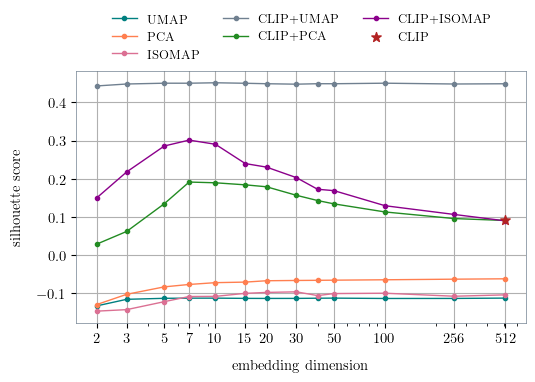

In [100]:
fig = plt.figure()
ax = plt.gca()
plt.grid()
for dim_reduction_technique in silhouette_scores["dim_reduction_technique"].unique():
    if dim_reduction_technique == "CLIP":
        pass
    else:
        x = silhouette_scores.query(f"dim_reduction_technique == '{dim_reduction_technique}'")["dimension"]
        y = silhouette_scores.query(f"dim_reduction_technique == '{dim_reduction_technique}'")["score"]
        ax.plot(x,y, marker ="o", ms = 3, label = dim_reduction_technique)

ax.scatter(512, silhouette_scores.query(f"dim_reduction_technique == 'CLIP'")["score"].values[0],
         marker = "*", s = 50, c= "firebrick", label = "CLIP", zorder = 3)

plt.xlabel("embedding dimension")
plt.ylabel("silhouette score")
plt.xscale("log")

plt.legend(ncol = 3, loc="lower center", bbox_to_anchor=(0.5, 1), frameon=False)
dims = silhouette_scores["dimension"].unique()
plt.xticks(dims[~np.isin(dims, [25,40])], dims[~np.isin(dims, [25,40])])

if save_plots:
    plt.savefig(f"plots/silhouette_scores_for_embeddings_of_{dataset_name}.png")

plt.show()

## 2.2 Performance of PLS depending on embedding

In [101]:
experiment = "vary_embedding_dimension"
dataset_name = "CIFAR10-H"
results = pd.read_csv(f"results/pls_{experiment}.csv")
results = results.query(f"dataset == '{dataset_name}'")
results.head()

,Unnamed: 0,dataset,n_data,dim_reduction_technique,dimension,prob_labels,alpha,n_samples,k,RMSE,Accuracy,KL,MAE,TV,runtime,config
0,0,CIFAR10-H,10000,CLIP,512,prob_label,0.99,100,20,0.223016,0.8004,1.118636,0.130219,0.645366,73.546852,configs/FGMRES.json
1,1,CIFAR10-H,10000,UMAP,512,prob_label,0.99,100,20,0.286331,0.2027,2.161438,0.162556,0.800566,11.440484,configs/FGMRES.json
2,2,CIFAR10-H,10000,UMAP,256,prob_label,0.99,100,20,0.281693,0.2285,2.026989,0.163846,0.807228,5.674828,configs/FGMRES.json
3,3,CIFAR10-H,10000,UMAP,100,prob_label,0.99,100,20,0.281973,0.2225,2.041107,0.161637,0.796497,2.759053,configs/FGMRES.json
4,4,CIFAR10-H,10000,UMAP,50,prob_label,0.99,100,20,0.282452,0.2158,2.051986,0.162074,0.797647,1.705962,configs/FGMRES.json


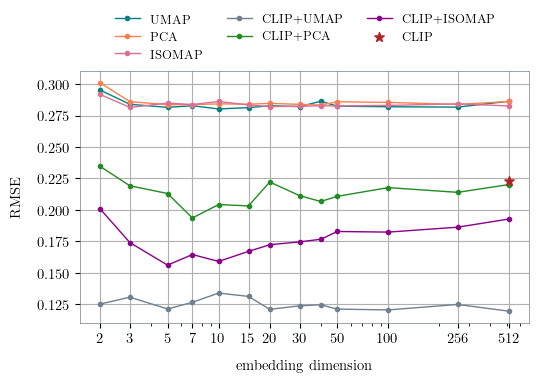

In [102]:
alpha = 0.99
quantity = "RMSE"
fig = plt.figure()
ax = plt.gca()
plt.grid()
for dim_reduction_technique in results["dim_reduction_technique"].unique():
    if dim_reduction_technique == "CLIP":
        pass
    else:
        x = results.query(f"alpha == {alpha} and dim_reduction_technique == '{dim_reduction_technique}'")["dimension"]
        y = results.query(f"alpha == {alpha} and dim_reduction_technique == '{dim_reduction_technique}'")[quantity]
        ax.plot(x,y, marker ="o", ms = 3, label = dim_reduction_technique)

# ax.hlines(results.query(f"alpha == {alpha} and dim_reduction_technique == 'CLIP'")["RMSE"].values[0],
#         results["dimension"].unique().min(), results["dimension"].unique().max(), label = "CLIP")
ax.scatter(512, results.query(f"alpha == {alpha} and dim_reduction_technique == 'CLIP'")[quantity].values[0],
         marker = "*", s = 50, c= "firebrick", label = "CLIP", zorder = 3)

plt.xlabel("embedding dimension")
plt.ylabel(quantity)
plt.xscale("log")


plt.legend(ncol = 3, loc="lower center", bbox_to_anchor=(0.5, 1), frameon=False)
dims = results["dimension"].unique()
plt.xticks(dims[~np.isin(dims, [25,40])], dims[~np.isin(dims, [25,40])])

if save_plots:
    plt.savefig(f"plots/performance_on_{dataset_name}_depending_on_embedding_alpha_0,99.png")

plt.show()

# 3 Ablation Studies: Different feature extractors & Solver tolerance

In [103]:
experiment_name = "ablation_feature_space"
df = pd.read_csv(f"results/pls_ablation_feature_space.csv")

df.loc[0,"runtime"] = df.loc[1, "runtime"] #  first entry is off due to data loading included

df.tail()

,Unnamed: 0,dataset,n_data,dim_reduction_technique,dimension,prob_labels,alpha,n_samples,k,RMSE,Accuracy,KL,MAE,TV,runtime,config
805,805,TinyImageNet,100000,VIT+UMAP,20,prob_label_effnetb0,0.99,10000,20,0.036299,0.69317,1.548960,0.004576,0.383480,148.459345,configs/FGMRES.json
806,806,TinyImageNet,100000,VIT+UMAP,20,prob_label_effnetb0,0.99,10000,20,0.036353,0.69226,1.566841,0.004591,0.384333,149.296246,configs/FGMRES.json
807,807,TinyImageNet,100000,VIT+UMAP,20,prob_label_effnetb0,0.99,10000,20,0.036230,0.69504,1.555033,0.004560,0.382137,149.779368,configs/FGMRES.json
808,808,TinyImageNet,100000,VIT+UMAP,20,prob_label_effnetb0,0.99,10000,20,0.036163,0.69402,1.553242,0.004535,0.379713,150.692347,configs/FGMRES.json
809,809,TinyImageNet,100000,VIT+UMAP,20,prob_label_effnetb0,0.99,10000,20,0.036298,0.69305,1.540851,0.004585,0.384163,148.494234,configs/FGMRES.json


In [104]:
alphas = [0.5, 0.9] # 
matplotlib.rcParams["axes.prop_cycle"] = cycler('color', ["teal"]*len(alphas) + ["coral"]*len(alphas) + ["palevioletred"]*len(alphas))


df1 = df.query("dim_reduction_technique == 'CLIP+UMAP' ").groupby(
    ["dataset", "k", "alpha", "n_samples"], as_index=False
).agg(
    Accuracy=("Accuracy", "mean"),
    Accuracy_std=("Accuracy", "std"),
    RMSE=("RMSE", "mean"),
    RMSE_std=("RMSE", "std"),
)
df2 = df.query("dim_reduction_technique == 'RESNET+UMAP' ").groupby(
    ["dataset", "k", "alpha", "n_samples"], as_index=False
).agg(
    Accuracy=("Accuracy", "mean"),
    Accuracy_std=("Accuracy", "std"),
    RMSE=("RMSE", "mean"),
    RMSE_std=("RMSE", "std"),
)
df3 = df.query("dim_reduction_technique == 'VIT+UMAP' ").groupby(
    ["dataset", "k", "alpha", "n_samples"], as_index=False
).agg(
    Accuracy=("Accuracy", "mean"),
    Accuracy_std=("Accuracy", "std"),
    RMSE=("RMSE", "mean"),
    RMSE_std=("RMSE", "std"),
)

In [105]:
# build one large table here with all the results
from IPython.display import Markdown
experiment = "evaluate_all_datasets"
dataset_name = "ANIMALS10"
datasets = ["ANIMALS10", "EMNIST", "CIFAR10", "CIFAR10-H", "TinyImageNet", "MTSD"]
header = ["Algorithm"] + ["Anim.10", "EMNIST-d.", "CIF.10", "CIF.10-H", "Tiny I.N.", "MTSD"]

na_placeholder = np.nan

budget = 0.1

rows = []

models = ["CLIP", "RESNET", "VIT"]
for model in models:
    for alpha in df["alpha"].unique():
        row = [model + ", $\\alpha$ = " + str(alpha)]
        for dataset_name in datasets:
            try:
                dim_red_tech = model + "+UMAP"
                n_samples = int(budget * df.query(f"dataset == '{dataset_name}'")["n_data"].values[0])
                row.append(df.query(f"dataset == '{dataset_name}' and dim_reduction_technique == '{dim_red_tech}' and alpha == {alpha} and n_samples == {n_samples}")["RMSE"].values[0])
            except:
                row.append(na_placeholder)
        rows.append(row)


# generate the table in latex format
table = pd.DataFrame(rows, columns = header)

# Find min values (excluding first column)
min_vals = table.iloc[:, 1:].min()

# Formatter function to format numbers and highlight the minimum
def format_value(x, col):
    if col == header[0]:  # First column, no formatting
        return str(x)
    return f"\\textbf{{{x:.3f}}}" if x == min_vals[col] else f"{x:.3f}"

# Apply formatting
table_formatted = table.apply(lambda col: col.apply(lambda x: format_value(x, col.name)))

# # Generate LaTeX code with tabularx
latex_code = table_formatted.to_latex(
    index=False, escape=False
).replace(
    "\\begin{tabular}", f"\\begin{{tabularx}}{{\\linewidth}}"
).replace(
    "\\end{tabular}", f"\\end{{tabularx}}"
).replace(
    "{" + "l" * len(header) + "}", "{l" + "r" * (len(header) - 1) + "}" # column alignment # "X"
)


# Add LaTeX float specifier, caption, and label
latex_code = (
    "\\begin{table}[!ht]\n\\centering\n"
    + f"\\caption{{RMSE for different datasets and feature extractors with {int(100*budget)}\\,\\% budget}}\n"
    + f"\\label{{tab:RMSE_all_datasets_{int(100*budget)}_percent}}\n"
    + latex_code
    + "\\end{table}"
)

# Add multirow and multicolumn manually
header_tex = (
    "\\multirow{2}{*}{\\textbf{Feature extractor}} & \\multicolumn{"
    + f"{len(header)-1}"
    + "}{c}{\\textbf{Datasets}} \\\\\n"
    + f"\\cmidrule(lr){{2-{len(header)}}}\n"
    + "& " + " & ".join(header[1:]) + " \\\\"
)

# Replace the first header row
latex_code = latex_code.replace("\\toprule\n" + " & ".join(header) + " \\\\", "\\toprule\n" + header_tex)


# Display in Markdown
from IPython.display import Markdown
Markdown(f"```latex\n{latex_code}\n```")

```latex
\begin{table}[!ht]
\centering
\caption{RMSE for different datasets and feature extractors with 10\,\% budget}
\label{tab:RMSE_all_datasets_10_percent}
\begin{tabularx}{\linewidth}{lrrrrrr}
\toprule
\multirow{2}{*}{\textbf{Feature extractor}} & \multicolumn{6}{c}{\textbf{Datasets}} \\
\cmidrule(lr){2-7}
& Anim.10 & EMNIST-d. & CIF.10 & CIF.10-H & Tiny I.N. & MTSD \\
\midrule
CLIP, $\alpha$ = 0.5 & 0.071 & 0.061 & 0.115 & 0.121 & 0.048 & 0.192 \\
CLIP, $\alpha$ = 0.9 & 0.065 & 0.057 & 0.106 & \textbf{0.109} & 0.043 & 0.122 \\
CLIP, $\alpha$ = 0.99 & \textbf{0.064} & 0.059 & 0.111 & 0.114 & 0.045 & 0.088 \\
RESNET, $\alpha$ = 0.5 & 0.077 & 0.079 & 0.118 & 0.129 & 0.042 & 0.192 \\
RESNET, $\alpha$ = 0.9 & 0.069 & 0.074 & 0.109 & 0.117 & 0.037 & 0.121 \\
RESNET, $\alpha$ = 0.99 & 0.066 & 0.079 & 0.113 & 0.123 & 0.039 & 0.089 \\
VIT, $\alpha$ = 0.5 & 0.090 & 0.060 & 0.113 & 0.122 & 0.041 & 0.190 \\
VIT, $\alpha$ = 0.9 & 0.085 & \textbf{0.056} & \textbf{0.104} & 0.109 & \textbf{0.036} & 0.119 \\
VIT, $\alpha$ = 0.99 & 0.086 & 0.058 & 0.107 & 0.112 & 0.036 & \textbf{0.087} \\
\bottomrule
\end{tabularx}
\end{table}
```

# 4 Entropy distribution of probabilistic labels

In [107]:
model_name = "effnetb0"  
# Load datasets only once
dataset_dict = {}
datasets = ["CIFAR10-H", "CIFAR10", "EMNIST", "MTSD", "TinyImageNet", "ANIMALS10"]

for dataset_name in datasets:
    if dataset_name not in ["CIFAR10-H", "MTSD"]:
        prob_label_column = "prob_label_"+model_name
    else:
        prob_label_column = "prob_label"

    df = pd.read_pickle(f"data/prob_data/{dataset_name}/{dataset_name}.pkl")
    labels = list(df["label"].unique())
    df["entropy"] = entropy(np.stack(df[prob_label_column].to_numpy()), axis=1) / np.log(len(labels))


    if prob_label_column != "prob_label":  
        df["pred"] = np.argmax(np.stack(df[prob_label_column].to_numpy()), axis=1)
        acc = len(df.query("pred == label")) / len(df)
    else:
        acc = None

    dataset_dict[dataset_name] = (df, acc)  # Store dataset + accuracy in a dictionary


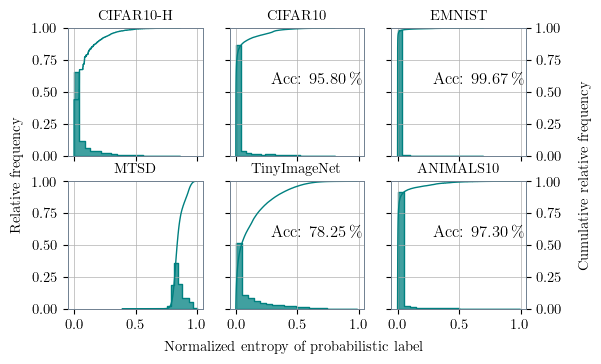

In [108]:
# Create subplots (2 rows, 3 columns)
fig, axes = plt.subplots(2, 3, sharex=True, sharey=True)
axes = axes.flatten()

# Plot each dataset
for i, dataset_name in enumerate(datasets):
    df, acc = dataset_dict[dataset_name]  # Retrieve preloaded dataset
    entropy_histogram(df, x="entropy", ax=axes[i], acc=acc, title=dataset_name, remove_ticks_of_second_yaxis=True)
    
    
    twin_ax = axes[i].twinx()  # Get or recreate secondary y-axis

    # Hide right y-axis ticks except for the last column in each row
    if (i + 1) % 3 != 0:  # Not the last column
        twin_ax.set_yticklabels([])
        twin_ax.set_yticks([])

# Set global x and y labels
fig.text(0.5, 0.01, "Normalized entropy of probabilistic label", ha="center")
fig.text(0.01, 0.55, "Relative frequency", va="center", rotation="vertical")
fig.text(0.99, 0.55, "Cumulative relative frequency", va="center", rotation="vertical")

fig.subplots_adjust(left=0.11, right=0.9, top=1, bottom=0.14)  # Adjust margins

if save_plots:
    plt.savefig("plots/entropy_comparison.jpg")
plt.show()